In [23]:
import json, sys
import pandas as pd; import seaborn as sns; import datetime
import geopandas as gpd
import shapely
from wordcloud import WordCloud
import matplotlib.pyplot as plt; import matplotlib.dates as mdates; import matplotlib.colors as colors; import matplotlib.ticker
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Make figures look good for hi-res displays.

# Use Pandas / etc. to clean and organize

In [53]:
def clean_name(name):
    return name.lower().replace(' ',"_")

In [54]:
bounds_file = 'data/states.geojson'

In [55]:
boundaries = json.load(open(bounds_file,'r'))

In [56]:
print("Found {} boundaries: ".format(str(len(boundaries['features']))))

user_files    = []
values_files  = []
geojson_files = []

for area in boundaries['features']:
    name = clean_name(area['properties']['NAME'])
    print("\t{}..".format(name), end = "")    

    user_files.append("results/json/{}_users.json".format(name))
    values_files.append("results/json/{}_values.json".format(name))
    geojson_files.append("results/geojson/{}.geojson".format(name))
    


Found 56 boundaries: 
	alaska..	alabama..	arkansas..	american_samoa..	arizona..	california..	colorado..	connecticut..	district_of_colombia..	delaware..	florida..	georgia..	hawaii..	iowa..	idaho..	illinois..	indiana..	kansas..	kentucky..	louisiana..	massachusetts..	maine..	michigan..	minnesota..	mississippi..	montana..	north_carolina..	north_dakota..	nebraska..	new_hampshire..	new_jersey..	new_mexico..	nevada..	new_york..	ohio..	oklahoma..	oregon..	pennsylvania..	puerto_rico..	rhode_island..	south_dakota..	tennessee..	texas..	utah..	virginia..	virgin_islands..	vermont..	washington..	wisconsin..	west_virginia..	wyoming..	missouri..	south_carolina..	guam..	northern_marianas..	maryland..

In [57]:
#This is basic cleaning for the states file
state_summaries = []

feature_collection = {'type':"FeatureCollection","features":[]}
for file in geojson_files:
    state = json.load(open(file))
    
    #quick 'n dirty cleaning
    for(k,v) in state['properties'].items():
        if type(v)==str:
            try:
                state['properties'][k] = float(v.replace(",",""))
            except:
                if v[-1] == "%":
                    try:
                        state['properties'][k] = float(v[:-1])
                    except:
                        continue
                continue
                
#   This would be the spot to normalize if needed.
                
    feature_collection['features'].append(json.loads(json.dumps(state)))
    
    state['properties']['geometry'] = shapely.geometry.shape( state['geometry'] )

    state_summaries.append(state['properties'])

In [58]:
json.dump(feature_collection, open("states_with_stats_raw.geojson",'w'))

In [59]:
#Also write this file to a web directory for downloadability
json.dump(feature_collection, open("/home/cc/www/states_with_stats_raw.geojson",'w'))

In [60]:
# Do basic normalization with pandas

In [61]:
df = gpd.GeoDataFrame(state_summaries, geometry='geometry')

In [62]:
df.head()

,NAME,Population,STATE,addrstreet,area_miles,building,dry_cleaning,geometry,highway,ice_cream,land_area_miles,land_percent,laundry,total_objects,water_area_miles,water_percent
0,Alaska,739795.0,AK,4803,665384.04,53592,1,"(POLYGON ((-179.107543945 51.30119705200008, -...",34770.542224,3,570640.95,85.76,27,347325,94743.10,14.24
1,Alabama,4874747.0,AL,26396,52420.07,169246,24,(POLYGON ((-88.11010742199994 30.2589111330000...,145261.897721,29,50645.33,96.61,33,851974,1774.74,3.39
2,Arkansas,3004279.0,AR,232315,53178.55,81612,17,(POLYGON ((-91.62986403299999 36.4992121600000...,129736.536492,16,52035.48,97.85,20,744313,1143.07,2.15
3,American Samoa,55641.0,AS,2,581.05,19967,0,"(POLYGON ((-170.773099 -14.362449, -170.773103...",337.675862,0,76.46,13.16,0,24626,504.60,86.84
4,Arizona,7016270.0,AZ,75230,113990.30,298832,29,"(POLYGON ((-110.490898132 37.00361251800007, -...",191033.673492,52,113594.08,99.65,62,1787795,396.22,0.35


In [63]:
df.set_index('STATE', inplace=True)

In [64]:
df['building_per_sqmi'] = df.building / df.area_miles
df['building_per_100k_people']  = df.building / df.Population * 100000
df['highway_per_sqmi']  = df.highway / df.area_miles
df['highway_per_100k_people']   = df.highway / df.Population * 100000
df['ice_cream_per_100k_people'] = df.ice_cream / df.Population * 100000
df['laundry_per_100k_people'] = df.laundry / df.Population * 100000
df['dry_cleaning_per_100k_people'] = df.dry_cleaning / df.Population * 100000
df['addresses_per_100k_people'] = df.addrstreet / df.Population * 100000

In [49]:
with open('states_with_stats_normalized.geojson','w') as out_geojson:
    out_geojson.write( df.to_json() )

# Make CSV files, sorted by top-editors

In [50]:
state_users = []
for file in user_files:
    u_df = pd.read_json( file )
    u_df.set_index('user', inplace=True)
    u_df = df.sort_values(by='total_objects',ascending=False)
    out_csv_file = 'results/csv/{}mappers.csv'.format(file.split("/")[-1][:-10]);
    u_df.to_csv(out_csv_file)
    sys.stderr.write("\rWrote {}                                                 ".format(out_csv_file))

Wrote results/csv/alabama_mappers.csv                                                 

# Wordcloud from values

In [39]:
for file in values_files:
    state_values = json.load(open(file))
    
    for key in state_values.keys():

        these_values = ""
        for k,v in state_values[key].items():
            these_values += (str(k)+" ") * int(v)
        output = "results/wordclouds/"+file.split("/")[-1][:-11]+"wordcloud_"+key+".png"
        
        sys.stderr.write("\rCreating Wordcloud: {}                                       ".format(output))
        
        wordcloud = WordCloud(
            width = 1000,
            height = 800,
            background_color = 'white',
            collocations=False,
            max_words=100).generate( these_values )
        
        wordcloud.to_file(output);

Creating Wordcloud: results/wordclouds/alabama_wordcloud_leisure.png                                       

In [40]:
# Do things with the dataframe...

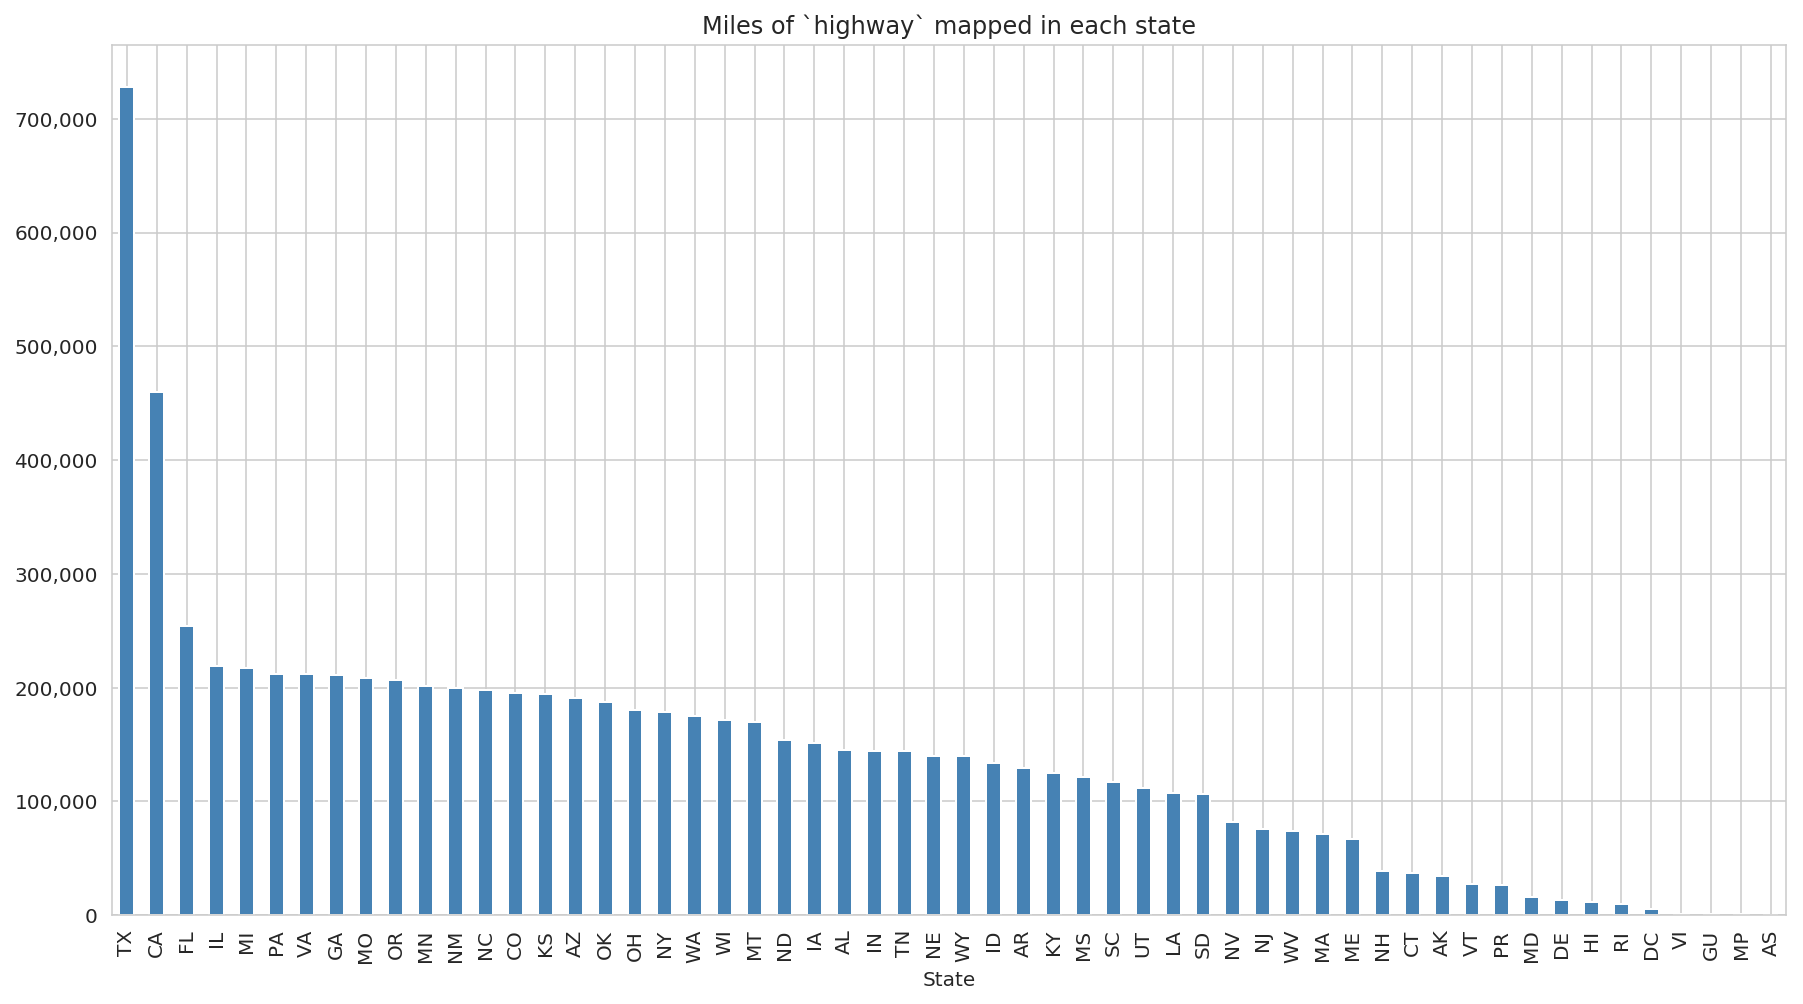

In [65]:
sns.set_style('whitegrid')
ax = df.sort_values(by='highway',ascending=False)['highway'].plot(kind='bar', figsize=(15,8), color='steelblue')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel("State")
ax.set_title("Miles of `highway` mapped in each state");


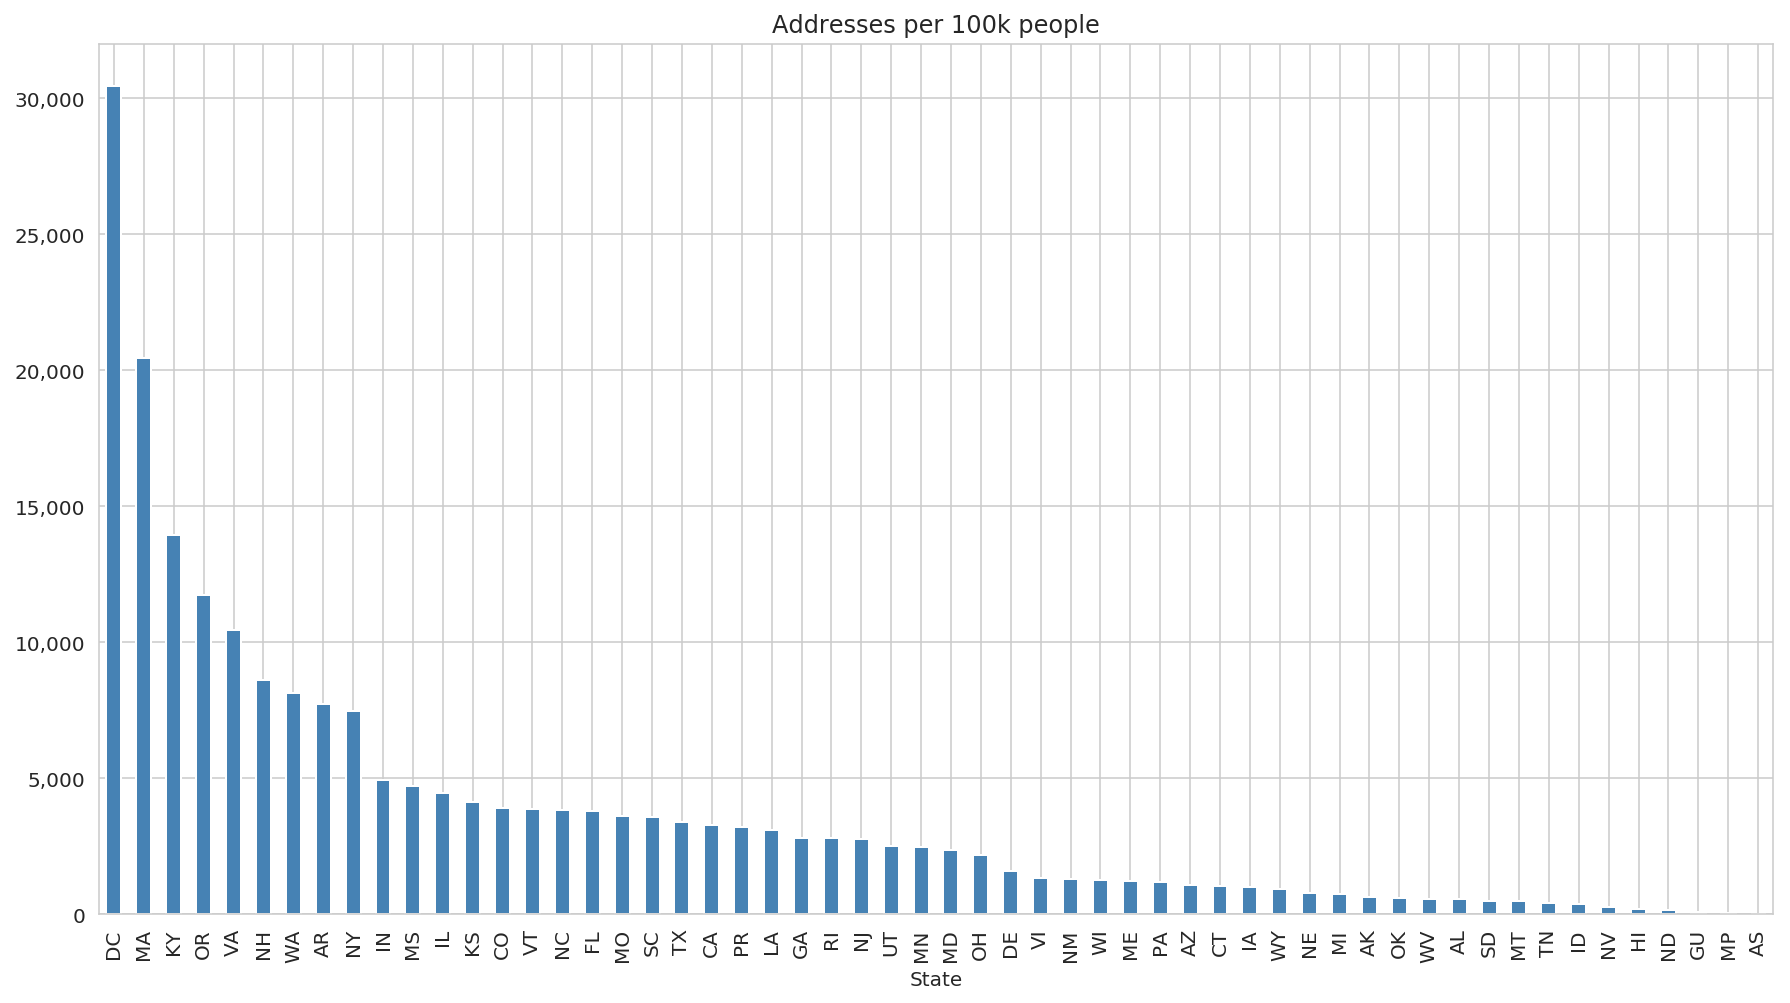

In [66]:
sns.set_style('whitegrid')
ax = df.sort_values(by='addresses_per_100k_people',ascending=False)['addresses_per_100k_people'].plot(kind='bar', figsize=(15,8), color='steelblue')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel("State")
ax.set_title("Addresses per 100k people");


In [67]:
df.sort_values(by='Population',ascending=False)

,NAME,Population,addrstreet,area_miles,building,dry_cleaning,geometry,highway,ice_cream,land_area_miles,...,water_area_miles,water_percent,building_per_sqmi,building_per_100k_people,highway_per_sqmi,highway_per_100k_people,ice_cream_per_100k_people,laundry_per_100k_people,dry_cleaning_per_100k_people,addresses_per_100k_people
STATE,,,,,,,,,,,,,,,,,,,,,
CA,California,39536653.0,1291637,163696.32,5250922,546,"(POLYGON ((-118.426203 32.799725, -118.426556 ...",460044.065544,555,155779.22,...,7915.52,4.84,32.077215,13281.149520,2.810351,1163.588798,1.403761,1.752804,1.380997,3266.935620
TX,Texas,28304596.0,960181,268596.46,3182209,168,"(POLYGON ((-97.199696 25.999317, -97.199624 26...",728012.062241,164,261231.71,...,7364.75,2.74,11.847546,11242.728919,2.710431,2572.063075,0.579411,0.671269,0.593543,3392.314803
FL,Florida,20984400.0,798435,65757.70,1726024,115,(POLYGON ((-81.96339416499995 24.5210971830000...,253985.131801,226,53624.76,...,12132.94,18.45,26.248242,8225.272107,3.862439,1210.352127,1.076991,0.848249,0.548026,3804.897924
NY,New York,19849399.0,1482451,54554.98,2224940,376,(POLYGON ((-73.72681123099989 40.5942085670000...,178997.144642,288,47126.40,...,7428.58,13.62,40.783445,11209.105122,3.281041,901.776143,1.450926,3.042913,1.894264,7468.493127
PA,Pennsylvania,12805537.0,151149,46054.35,825770,201,(POLYGON ((-79.76219940199996 42.2689132690000...,212250.348487,327,44742.70,...,1311.64,2.85,17.930337,6448.538628,4.608693,1657.488854,2.553583,1.991326,1.569634,1180.340973
IL,Illinois,12802023.0,571051,57913.55,1291065,121,(POLYGON ((-90.63999938999996 42.5084114070000...,218735.807601,165,55518.93,...,2394.62,4.13,22.292969,10084.851433,3.776937,1708.603457,1.288859,0.898296,0.945163,4460.630949
OH,Ohio,11658609.0,253211,44825.58,726466,105,"(POLYGON ((-82.65703600000001 41.437128, -82.6...",180291.914009,267,40860.69,...,3964.89,8.85,16.206505,6231.155020,4.022077,1546.427314,2.290153,1.089324,0.900622,2171.880024
GA,Georgia,10429379.0,292508,59425.15,534237,63,(POLYGON ((-81.49619293199999 30.7323398590000...,211005.120080,39,57513.49,...,1911.66,3.22,8.990082,5122.423876,3.550771,2023.180096,0.373944,0.565710,0.604063,2804.654045
NC,North Carolina,10273419.0,392067,53819.16,650139,119,(POLYGON ((-77.50814056399997 34.4506759640000...,198194.624439,131,48617.91,...,5201.25,9.66,12.080066,6328.360597,3.682603,1929.198297,1.275135,0.768975,1.158329,3816.324439


In [69]:
df[df.NAME=="Maryland"]

,NAME,Population,addrstreet,area_miles,building,dry_cleaning,geometry,highway,ice_cream,land_area_miles,...,water_area_miles,water_percent,building_per_sqmi,building_per_100k_people,highway_per_sqmi,highway_per_100k_people,ice_cream_per_100k_people,laundry_per_100k_people,dry_cleaning_per_100k_people,addresses_per_100k_people
STATE,,,,,,,,,,,,,,,,,,,,,
MD,Maryland,6052177.0,142306,12405.93,291312,22,"(POLYGON ((-75.841849 37.96483200000011, -75.8...",15908.076378,32,9707.24,...,2698.69,21.75,23.481674,4813.342373,1.282296,262.848829,0.528735,0.33046,0.363506,2351.319203
